In [2]:
# 음성인식 : cnn + rnn + dnn

import os
import numpy as np
import pandas as pd
import random
from time import time

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical

from tqdm import tqdm
import librosa
import librosa.display
import matplotlib.pyplot as plt

from keras.layers import Bidirectional, BatchNormalization
from keras.layers import GRU, Dense, Dropout
from keras.layers import Conv1D, MaxPool1D, Input
from keras.models import Model


In [3]:
# 하이퍼 파라미터 설정

my_split = 0.8
my_hidden = 128
my_drop = 0.3
my_batch = 100
my_epoch = 100
my_rate = 8000

# 모드 선택

data_mode = 0
train_mode = 0

# 데이터 저장 창고

all_wave = []       # 처리된 음성 데이터
all_label = []      # 처리된 음성 라벨

my_path = '데이터셋/audio'

오디오 데이터 원본 : [ 1.2472774e-04 -1.0550164e-04 -2.6962085e-04 ...  5.1089493e-05
  3.3633485e-05 -2.3895914e-06]
오디오 데이터 길이 : 22050


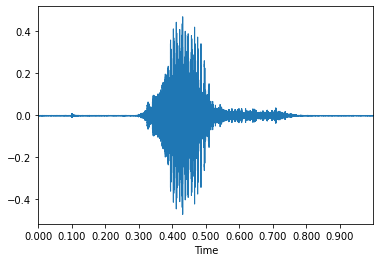

In [4]:
# 음성 라벨 처리

labels = ['go', 'happy', 'seven', 'stop', 'yes']


# 샘플 오디오 파일 읽기

path = os.path.join(my_path, 'SKL-yes.wav')

sound, rate = librosa.load(path)

print('오디오 데이터 원본 :', sound)        # *sound은 전체 찍기
print('오디오 데이터 길이 :', len(sound))   # 22.05 khz  =  22050 hz


# 오디오 데이터 시각화

librosa.display.waveplot(sound, rate)

In [5]:
# 오디오 다운 샘플링

def read_wave():
    print('resampling start')

    # tqdm 함수로 진행 상황 출력
    for label in tqdm(labels):
        path = my_path + '/' + label

        waves = [file for file in os.listdir(path)]
        # print(waves)

        for wav in waves:
            full_path = path + '/' + wav
            # sprint(full_path)
            sound, rate = librosa.load(full_path)

            # 8khz로 다운 샘플링
            # 22050개의 숫자를 8000개로 줄이는 과정
            # librosa의 resample 함수는 성공의 보장이 없음
            new_sample = librosa.resample(sound, orig_sr=rate, target_sr=my_rate)

            # 따라서 다운 샘플링이 성공적으로 8khz로 된 것만 저장
            if (len(new_sample)==8000):
                all_wave.append(new_sample)
                all_label.append(label)
    
    print('resampling finished')
    print('정상 다운 샘플링 처리된 데이터 수 :', len(all_wave))


In [6]:
# 라벨 처리 (토큰 처리)

# sklearn의 라벨 처리 : 시작 숫자 0
# keras의 라벨 처리 : 시작 숫자 0

def wave_label_encoding():
    global all_label, all_wave

    # print('토큰 처리 전 라벨 :', all_label)

    encoder = LabelEncoder()

    all_label = encoder.fit_transform(all_label)

    # print('토큰 처리 후 라벨 :', all_label)

    # 원핫 인코딩 처리
    all_label = to_categorical(all_label, 5)

    # 넘파이로 변환, -1 은 keras가 알아서 계산하라는 뜻
    all_wave = np.array(all_wave)
    all_wave = all_wave.reshape(-1, my_rate, 1)



In [7]:
# control cell
path = os.path.join(my_path, 'audio.npy')

if data_mode:
    read_wave()
    wave_label_encoding()
    
    with open(path, 'wb') as file:
        np.save(file, all_wave)
        np.save(file, all_label)

    print('데이터 처리 및 저장 완료')
else:
    with open(path, 'rb') as file:
        all_wave = np.load(file)
        all_label = np.load(file)

    print('데이터 파일 읽기 완료')

데이터 파일 읽기 완료


In [8]:
# 데이터 4분할
x_train, x_test, y_train, y_test = train_test_split(all_wave,
                                                    all_label,
                                                    train_size=my_split,
                                                    shuffle=True)

# 데이터 모양
print('학습용 입력:', x_train.shape)
print('학습용 출력:', y_train.shape)

print('평가용 입력:', x_test.shape)
print('평가용 출력:', y_test.shape)

학습용 입력: (711, 8000, 1)
학습용 출력: (711, 5)
평가용 입력: (178, 8000, 1)
평가용 출력: (178, 5)


In [9]:
# 음성 인식기 구현
# 입력층
my_input = Input(shape=(my_rate, 1))

# 2번 그룹
x = BatchNormalization()(my_input)
x = Conv1D(filters=8, kernel_size=13, activation='relu')(x)
x = MaxPool1D(pool_size=3)(x)
x = Dropout(my_drop)(x)

# 3번 그룹
x = Conv1D(filters=16, kernel_size=11, activation='relu')(x)
x = MaxPool1D(pool_size=3)(x)
x = Dropout(my_drop)(x)

# 4번 그룹
x = Conv1D(filters=32, kernel_size=9, activation='relu')(x)
x = MaxPool1D(pool_size=3)(x)
x = Dropout(my_drop)(x)
x = BatchNormalization()(x)

# 5번 그룹
x = Bidirectional(GRU(units=my_hidden, return_sequences=True), merge_mode='sum')(x)
x = Bidirectional(GRU(units=my_hidden, return_sequences=True), merge_mode='sum')(x)
x = Bidirectional(GRU(units=my_hidden, return_sequences=False), merge_mode='sum')(x)

# 6번 그룹
x = BatchNormalization()(x)
x = Dense(units=256, activation='relu')(x)
x = Dense(units=10, activation='relu')(x)
x = Dense(units=5, activation='softmax')(x)

# 인공 신경망 요약
model = Model(inputs=my_input, outputs=x)
model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 8000, 1)]         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 8000, 1)           4         
_________________________________________________________________
conv1d (Conv1D)              (None, 7988, 8)           112       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 2662, 8)           0         
_________________________________________________________________
dropout (Dropout)            (None, 2662, 8)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2652, 16)          1424      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 884, 16)           0     

In [10]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['acc']
)

path = my_path + '/audio.h5'

if train_mode:

    model.fit(
        x_train,
        y_train,
        epochs=my_epoch,
        batch_size=my_batch,
        verbose=1
    )
    model.save_weights(path)
else:
    model.load_weights(path)

In [11]:
# 모델 평가

score = model.evaluate(x_test, y_test)

print(score[1])

6/6 [==============================] - 4s 136ms/step - loss: 0.2456 - acc: 0.9049
0.915730357170105


음성 데이터 원본 길이 : 41396
음성 데이터 자른 길이 : 8000
음성 다운 샘플링 결과 :  8000
<class 'numpy.ndarray'>
(8000,)
(1, 8000, 1)
내 음생 예측 결과 : yes


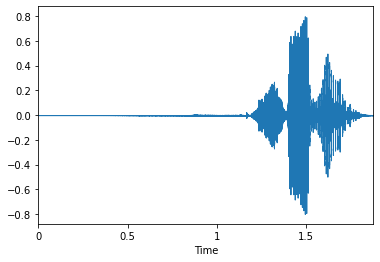

In [12]:
# 모델로 예측

path = my_path + '/seven.wav'

sound, rate = librosa.load(path)

print('음성 데이터 원본 길이 :', len(sound))
librosa.display.waveplot(sound, rate)

def split_wav(data, sample_rate, start, end):
    start *= sample_rate
    end *= sample_rate
    return data[int(start):int(end)]

center = len(sound)/2
edited_data = split_wav(sound, my_rate, (center-(my_rate/2))/my_rate, (center+(my_rate/2))/my_rate) # 2, 4.756

print('음성 데이터 자른 길이 :', len(edited_data))
# sound = librosa.resample(edited_data, orig_sr=rate, target_sr=my_rate)

sound = edited_data

print('음성 다운 샘플링 결과 : ', len(sound))

if len(sound) == my_rate:
    print(type(sound)) # input type은 항상 넘파이 형태
    print(sound.shape)

    sound = np.reshape(sound, (1, my_rate, 1)) # 제일 앞의 1은 배치 정보, 데이터의 수, 한번에 처리할 데이터 수

    print(sound.shape)


    pred = model.predict(sound)

    # 'go' : 0, 'happy' : 1, 'seven' : 2, 'stop' : 3, 'yes' : 4
    print('내 음생 예측 결과 :', labels[pred.argmax()])